## Training excitatory-inhibitory recurrent network

Here we will train recurrent neural network with excitatory and inhibitory neurons on a simple perceptual decision making task.

In [2]:
# Install neurogym to use cognitive tasks
# ! git clone https://github.com/gyyang/neurogym.git
# %cd neurogym/
# ! pip install -e .

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'Arial'

import gym
from gym import spaces
import neurogym
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

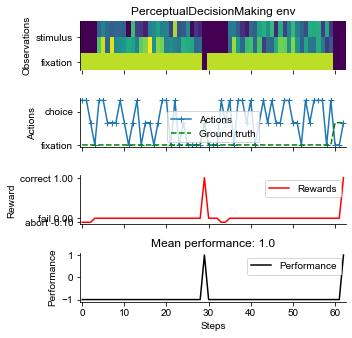

In [105]:
import neurogym as ngym

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {'stimulus': ('constant', 500)}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [106]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class PosWLinear(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Same as nn.Linear, except that weight matrix is constrained to be non-negative
    """
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(PosWLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

#     def reset_parameters(self):
#         init.kaiming_uniform_(self.weight, a=math.sqrt(5))
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in)
#             init.uniform_(self.bias, -bound, bound)

    def reset_parameters(self):
        # the default for Linear, kaiming_uniform wouldn't work here
        init.eye_(self.weight)
        self.weight.data = self.weight.data * 0.5  # scaled identity matrix
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, torch.abs(self.weight), self.bias)
    
    
class EIRecLinear(nn.Module):
    r"""Recurrent E-I Linear transformation.
    
    Args:
        hidden_size: int, layer size
        e_prop: float between 0 and 1, proportion of excitatory units
    """
    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size)
        self.i_size = hidden_size - self.e_size
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
        np.fill_diagonal(mask, 0)
        self.mask = torch.tensor(mask, dtype=torch.float32)
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale E weight by E-I ratio
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

#     def reset_parameters(self):
#         # the default for Linear, kaiming_uniform wouldn't work here
#         init.eye_(self.weight)
#         self.weight.data = self.weight.data * 0.5  # scaled identity matrix
#         if self.bias is not None:
#             fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
#             bound = 1 / math.sqrt(fan_in)
#             init.uniform_(self.bias, -bound, bound)
    
    def effective_weight(self):
        return torch.abs(self.weight) * self.mask

    def forward(self, input):
        # weight is non-negative
        return F.linear(input, self.effective_weight(), self.bias)


class EIRNN(nn.Module):
    """E-I RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None, e_prop=0.8, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        # self.input2h = PosWLinear(input_size, hidden_size)
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

#     def recurrence(self, input, hidden):
#         """Recurrence helper."""
#         e_hidden, i_hidden = torch.split(
#             hidden, (self.e_size, self.i_size), dim=1)
#         pre_activation = (self.input2h(input) +
#                           self.e2h(e_hidden) -
#                           self.i2h(i_hidden))
#         h_new = torch.relu(hidden * self.oneminusalpha +
#                            pre_activation * self.alpha)
#         return h_new

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.cat(output, 0).view(input.size(0), *output[0].size())
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        # self.fc = PosWLinear(self.rnn.e_size, output_size)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [107]:
import torch.optim as optim

# Instantiate the network and print information
hidden_size = 100
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, activity = net(inputs)
    
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 200 == 199:
        running_loss /= 200
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

RNNNet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 100, Loss 0.6101
Step 200, Loss 0.4123
Step 300, Loss 0.3141
Step 400, Loss 0.2574
Step 500, Loss 0.2202
Step 600, Loss 0.1868
Step 700, Loss 0.1576
Step 800, Loss 0.1357
Step 900, Loss 0.1206
Step 1000, Loss 0.1062
Step 1100, Loss 0.1030
Step 1200, Loss 0.0956
Step 1300, Loss 0.0908
Step 1400, Loss 0.0848
Step 1500, Loss 0.0849
Step 1600, Loss 0.0850
Step 1700, Loss 0.0764
Step 1800, Loss 0.0746
Step 1900, Loss 0.0747
Step 2000, Loss 0.0730


In [112]:
import numpy as np
env.reset(no_step=True)
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
selectivity = np.zeros((2, hidden_size))
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)
    
    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]
    
    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    
    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    stim_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    selectivity[env.trial['ground_truth']] += np.mean(stim_activity, axis=0)  # average over time
    
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))
    
for gt in [0, 1]:
    selectivity[gt] /= np.sum([val['ground_truth'] == gt for val in trial_infos.values()])

# TODO: replace with d'
selectivity = (selectivity[0] - selectivity[1])/(selectivity[0] + selectivity[1] + 1e-7)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:net.rnn.e_size]),
                           np.argsort(selectivity[net.rnn.e_size:])+net.rnn.e_size))

Average performance 0.846


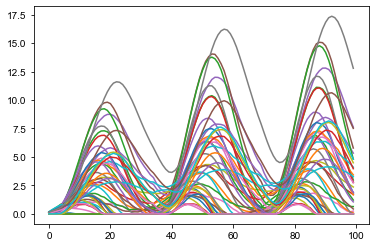

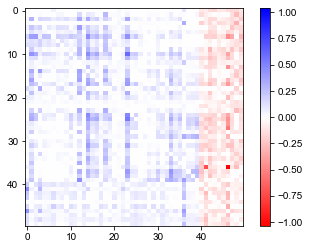

In [111]:
# _ = plt.plot(activity.detach().numpy()[:, 0, :])

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()